In [104]:
import torch
from  torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


X_small
Y_medium
Y_large
0 torch.Size([8, 72, 72, 3]) torch.Size([8, 144, 144, 3])
1 torch.Size([8, 72, 72, 3]) torch.Size([8, 144, 144, 3])
2 torch.Size([8, 72, 72, 3]) torch.Size([8, 144, 144, 3])
3 torch.Size([8, 72, 72, 3]) torch.Size([8, 144, 144, 3])


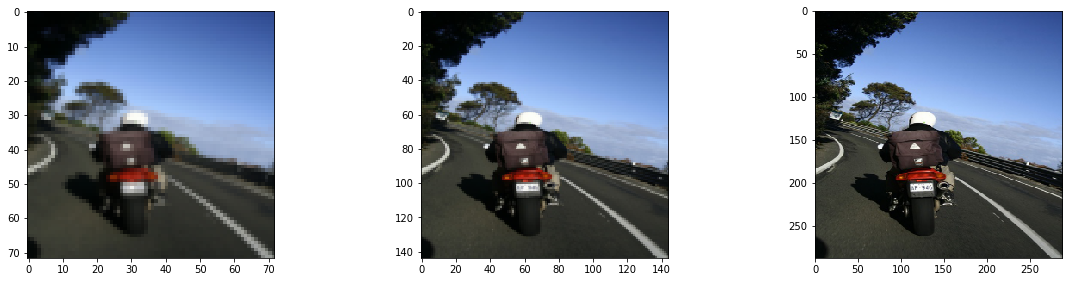

In [97]:
class PascalDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        files = [name for name in os.listdir(self.root_dir) if os.path.isfile('/'.join([self.root_dir, name]))]
        files.sort()
        self.files = files
        
    def __len__(self):
#         print(self.files)
        return len(self.files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.files[idx])
        image = io.imread(img_name)

        return image
        
class TransformingDataset(Dataset):
        def __init__(self, ds, transforms, keys):
            self.ds = ds
            self.keys_transforms = list(zip(keys, transforms))
            
        def __len__(self):
            return len(self.ds)
        
        def __getitem__(self, idx):
            it = self.ds[idx]
            return {name:f(it) for (name,f) in self.keys_transforms } 
#             return it, list(map(lambda f: f(it), self.transforms))
        
        def number_of_transforms(self):
            return len(self.keys_transforms)


ds = PascalDataset('VOCdevkit/VOC2007/JPEGImages')

resizer = lambda output_shape: (lambda img: transform.resize(img, output_shape) )

torch.set_printoptions(profile="full")


resize_large = resizer((288, 288, 3))
resize_medium = resizer((144, 144, 3))
resize_small = resizer((72, 72, 3))


ds_small_medium_large = TransformingDataset(ds, [resize_small, resize_medium, resize_large], 
                                            ['X_small', 'Y_medium', 'Y_large'])

def present(idx, dataset):
    plt.figure(figsize=(20,10))
    columns = dataset.number_of_transforms()
    data_dict = dataset[idx]
    for i, transformation in enumerate(data_dict):
        plt.subplot(len(data_dict) / columns + 1, columns, i + 1)
        print(transformation)
        plt.imshow(data_dict[transformation])
        
plt.show()

present(np.random.randint(len(ds)), ds_small_medium_large)

dataloader = DataLoader(ds_small_medium_large, batch_size=8, shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['X_small'].size(), sample_batched['Y_medium'].size())

    if i_batch == 3:
        break

In [122]:
class FirstModel(nn.Module):
    def __init__(self, out_channels, input_h_w=(72, 72), output_h_w=(144, 144)):
        super(FirstModel, self).__init__()
        self.input_h_w = input_h_w
        self.output_h_w = output_h_w
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=out_channels, padding = 1, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, padding = 1, kernel_size=3)
        self.final_conv = nn.Conv2d(in_channels=out_channels,out_channels=3, padding = 1, kernel_size=3)
#         self.upsample = nn.functional.interpolate()
#         self.upsample = nn.ConvTranspose2d(in_channels=out_channels, out_channels=1, kernel_size=1)

    def forward(self, x):
        x = x.view(-1, 3, self.input_h_w[0], self.input_h_w[1]).float()
#         print(x.shape)
        #torch.Size([B, 3, H, W])
        x = F.relu(self.conv1(x))
#         print(x.shape)
        #torch.Size([B, 64, H, W])
        x = F.relu(self.conv2(x))
#         print(x.shape)
        #torch.Size([B, 64, H, W])
        x = nn.functional.interpolate(x, size=self.output_h_w)
#         print(x.shape)
        x = F.relu(self.final_conv(x))
#         print(x.shape)
        return x
    

model = FirstModel(64).float()

# plt.imshow(model(torch.from_numpy(ds_small[0])).squeeze(0).view(144,144,3).detach().numpy())
print(ds_small_medium_large[0])
model(torch.from_numpy(ds_small_medium_large[0]['X_small']))


{'X_small': array([[[0.18271832, 0.20747322, 0.21190087],
        [0.12797522, 0.14096541, 0.14166667],
        [0.08663081, 0.09488244, 0.09177787],
        ...,
        [0.67829521, 0.77290078, 0.8037854 ],
        [0.65890523, 0.7572372 , 0.78509668],
        [0.64354575, 0.74157362, 0.76903595]],

       [[0.3827342 , 0.46519608, 0.48210784],
        [0.38921569, 0.45855801, 0.47816585],
        [0.37150735, 0.4336329 , 0.45091912],
        ...,
        [0.68450436, 0.78291803, 0.81036901],
        [0.6626634 , 0.76102941, 0.79207516],
        [0.63820125, 0.74016204, 0.77145969]],

       [[0.40204248, 0.48831699, 0.5078681 ],
        [0.41552968, 0.50180419, 0.52141204],
        [0.4289488 , 0.51346451, 0.53537582],
        ...,
        [0.39270153, 0.44685231, 0.45816993],
        [0.34232026, 0.37695398, 0.38839869],
        [0.29398148, 0.31895198, 0.32276688]],

       ...,

       [[0.0999183 , 0.04313725, 0.0255719 ],
        [0.10318627, 0.03921569, 0.01788535],
        [0

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
      

In [123]:
def train(model, criterion, optimizer, dataloader, epochs=1, data_key='X_small', target_key='Y_medium'):
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data_dict in enumerate(dataloader, 0):
            X = data_dict[data_key]
            Y = data_dict[target_key]
            Y = Y.float()
            optimizer.zero_grad()

            Y_pred = model(X)
            Y_pred = Y_pred.view(Y.shape)

            loss = criterion(Y_pred, Y)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(running_loss / 100)
                running_loss = 0.0
        
    pass

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, dataloader)

0.0025105386972427367


KeyboardInterrupt: 